In [1]:
# Characterize germline insertions

In [2]:
from collections import (
    defaultdict,
    namedtuple,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
import scipy.stats
import seaborn as sns


TUMOR_PAIRS = {
    'H1': 'H3',
    'H4': 'H6',
    'H7': 'H9',
    'R1': 'R2',
    'R3': 'R4',
    'R5': 'R6',
    'R7': 'R8',
    'R9': 'R10',
    'R11': 'R12',
    'R13': 'R14',
    'R17': 'R18',
    'R19': 'R20',
    'R21': 'R22',
    'R23': 'R24',
    'R25': 'R26',
    'R27': 'R28',
    'R29': 'R30',
    'R31': 'R32',
    'R33': 'R34',
    'R35': 'R36',
    'R37': 'R38',
    'R39': 'R40',
    'R41A': 'R42A',
    'R41B': 'R42B',
    'R43': 'R44',
    'R45': 'R46',
    'R49': 'R50',
    'R51': 'R52',
    'R53': 'R54',
    'R55': 'R56',
    'R57': 'R58',
    'R59': 'R60',
    'R61': 'R62',
    'R63': 'R64',
}
HEAD_PAIRS = {v:k for k,v in TUMOR_PAIRS.items()}
PAIRS = TUMOR_PAIRS.copy()
PAIRS.update({v:k for k,v in PAIRS.items()})


COLUMNS = ['chrom', 'program', 'insertion', 'start', 'end', 'score', 'strand', 'idk', 'attributes']
insertion = namedtuple('Insertion', COLUMNS)

In [3]:
PREFIX = 'Pros Germline'
PUTATIVE_INSERTIONS = '../../pre-processed-data/raw_insertion_calls/all_putative_germline_insertions.gff3'
# PUTATIVE_INSERTIONS = '../../pre-processed-data/insertion_calls/coverage/combined_sorted_somatic_insertions.gff'
COVERAGE_FILE = '../../pre-processed-data/raw_insertion_calls/coverage_over_germline_insertions.tsv'
# COVERAGE_FILE = '../../pre-processed-data/insertion_calls/coverage/d'
ALL_INSERTIONS = '/Users/mvandenb/Downloads/Galaxy1199-[Concatenate_multiple_datasets_on_data_1198,_data_1197,_and_others].gff3'
# ALL_INSERTIONS = PUTATIVE_INSERTIONS
SOMATIC_DATA = ['../../pre-processed-data/insertion_calls/0.5.21.filtered_calls_prosgfp_guts.gff', '../../pre-processed-data/insertion_calls/0.5.21.filtered_calls_prosgfp_heads.gff']
INSERTION_SUMMARY = f'{PREFIX} TSD insertions.tsv'
FINAL_TABLE = f'{PREFIX} table.tsv'
VAF_TABLE_NORMALIZED = f'{PREFIX} vaf table.tsv'

In [4]:
summary = namedtuple('summary', 'chrom start mate_support split_support nref vaf')


def read_insertions(path):
    all_inserts = defaultdict(list)
    with open(path) as in_fh:
        for line in in_fh:
            fields = line.split()
            chrom = fields[0]
            start = int(fields[3])
            attributes = dict(item.split("=") for item in fields[8].split(";"))
            mate_support = int(attributes['left_mate_count']) + int(attributes['right_mate_count'])
            total_support = int(attributes['total_left_count']) + int(attributes['total_right_count'])
            split_support = total_support - mate_support
            nref = int(attributes['nref'])
            vaf = total_support / (total_support + nref)
            all_inserts[attributes['ID']].append((summary(chrom, start, mate_support, split_support, nref, vaf)))
    return all_inserts

all_inserts = read_insertions(ALL_INSERTIONS)

In [5]:
def find_overlap_support(all_inserts, cluster_id, chrom, start):
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.mate_support, insert.split_support
    return 0, 0

def find_nref(all_inserts, cluster_id, chrom, start):
    # nref = []
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.nref
    return 0

def find_vaf(all_inserts, cluster_id, chrom, start):
    # vaf = []
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.vaf
    return 0

In [6]:
def summarize_overlaps(insertions):
    overlaps = set()
    cluster_ids = set()
    if not insertions:
        raise Exception('nope')
    for index, ins in enumerate(insertions):
        overlaps.add(ins.attributes['ID'].split('_')[0])
        cluster_ids.add(ins.attributes['ID'])
        for overlap in ins.attributes['overlaps'].split(','):
            if overlap:
                cluster_ids.add(overlap)
                overlaps.add(overlap.split('_')[0])
        is_somatic  = (ins.chrom, ins.start, ins.end, ins.insertion) in somatic
    return [index, ins.chrom, ins.start, ins.end, ins.insertion, ins.strand, ins.attributes['genotype'], is_somatic, len(overlaps), cluster_ids]


def get_insertions_by_coordinate(path):
    insertions_by_coordinate = defaultdict(list)
    with open(path) as fh:
        for line in fh:
            fields = line.strip().split('\t')
            fields[8] = dict(item.split("=") for item in fields[8].split(";"))
            ins = insertion(*fields)
            if ins.attributes['valid_TSD'] == 'True':
                insertions_by_coordinate[(ins.chrom, ins.start, ins.end, ins.insertion)].append(ins)
    return insertions_by_coordinate


insertions_by_coordinate = get_insertions_by_coordinate(PUTATIVE_INSERTIONS)


somatic = defaultdict(list)
for dataset in SOMATIC_DATA:
    somatic.update(get_insertions_by_coordinate(dataset))

somatic = {ins: summarize_overlaps(somatic[ins]) for ins in somatic}

In [7]:
len(insertions_by_coordinate)

3650

In [8]:
possible_somatic = {k:v for k, v in insertions_by_coordinate.items() if sum(1 for _ in v if _.attributes['overlaps'].count(',') == 0) == len(v)}

In [9]:
len(possible_somatic)

476

In [10]:
possible_private = defaultdict(list)

for insertions in insertions_by_coordinate.values():
    for record in insertions:
        overlaps = [overlap.split('_')[0] for overlap in record.attributes['overlaps'].split(',')]
        if len(overlaps) == 2 and PAIRS[overlaps[0]] == overlaps[1] and record.attributes['valid_TSD'] == 'True':
            possible_private[(record.chrom, record.start, record.end, record.insertion)].append(record)

In [11]:
early_somatic = {k:v for k,v in possible_private.items() if len(v) == 1}

In [12]:
private = {k:v for k,v in possible_private.items() if len(v) == 2}

In [13]:
def merge_connected_clusters(shared_summary):
    new_summary = []
    n_insertions = len(shared_summary)
    skip = -1
    for i, s in enumerate(shared_summary):
        if not skip == i:
            if i < (n_insertions - 1):
                n_s = shared_summary[i + 1]
                if s[-1] & n_s[-1]:
                    s[-1] = s[-1].union(n_s[-1])
                    skip = i + 1
            s[-2] = len(set(overlap.split('_')[0] for overlap in s[-1]))
            new_summary.append(s)
    return new_summary

<AxesSubplot:xlabel='Number of samples with insertion', ylabel='Number of insertion'>

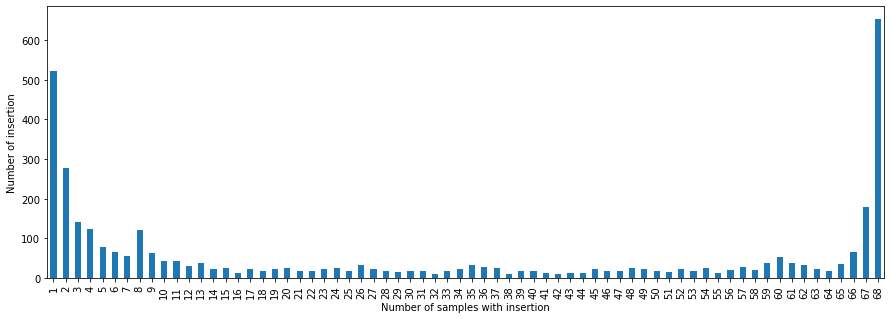

In [14]:
shared_germline = set(insertions_by_coordinate.keys()) - set(possible_somatic.keys()) - set(private.keys())
shared_summary = [summarize_overlaps(insertions_by_coordinate[ins]) for ins in insertions_by_coordinate]

# Make that a recursive call
new_summary = merge_connected_clusters(shared_summary)
new_summary = merge_connected_clusters(list(reversed(new_summary)))
new_summary = merge_connected_clusters(new_summary)
new_summary = list(reversed(merge_connected_clusters(list(reversed(new_summary)))))

shared_df = pd.DataFrame.from_records(shared_summary)
shared_df.columns = ['index', 'chrom', 'start', 'end', 'insertion', 'strand', 'genotype', 'somatic', 'N_samples', 'overlaps']
shared_df['support'] = shared_df.apply(lambda row: [find_overlap_support(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['nref'] = shared_df.apply(lambda row: [find_nref(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['vaf'] = shared_df.apply(lambda row: [find_vaf(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion")

<AxesSubplot:xlabel='Number of samples with insertion, merge aggressively', ylabel='Number of insertion'>

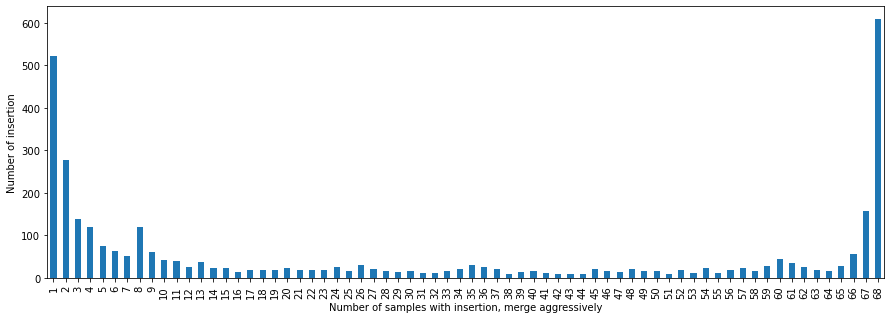

In [15]:
shared_df = pd.DataFrame.from_records(new_summary)
shared_df.columns = ['index', 'chrom', 'start', 'end', 'insertion', 'strand', 'genotype', 'somatic', 'N_samples', 'overlaps']
shared_df['support'] = shared_df.apply(lambda row: [find_overlap_support(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['nref'] = shared_df.apply(lambda row: [find_nref(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['vaf'] = shared_df.apply(lambda row: [find_vaf(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
# shared_df = shared_df[shared_df.somatic == False]
shared_df.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion, merge aggressively")

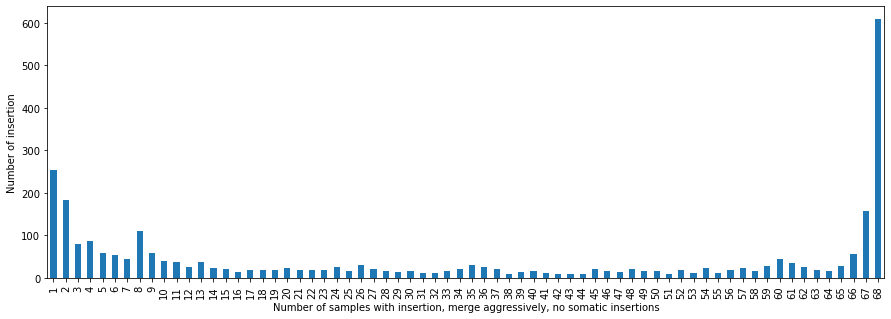

In [16]:
shared_df.somatic = shared_df.apply(lambda row: (row.chrom, row.start, row.end, row.insertion) in somatic, axis=1)
shared_df['private'] = shared_df.apply(lambda row: (row.chrom, row.start, row.end, row.insertion) in possible_private, axis=1)
shared_df.somatic.value_counts()
no_somatic = shared_df[(shared_df.somatic == False)]
if not no_somatic.empty:
    no_somatic.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion, merge aggressively, no somatic insertions")

In [17]:
pretty_summary = shared_df[['chrom', 'start', 'end', 'insertion', 'somatic', 'private', 'N_samples', 'overlaps']]

In [18]:
pretty_summary.to_csv(INSERTION_SUMMARY, sep='\t', index=None)

In [19]:
pretty_summary

,chrom,start,end,insertion,somatic,private,N_samples,overlaps
0,Y,3634227,3634257,gypsy,False,False,11,"{R7_gut_221, R45_gut_179, R24_head_234, R45_gu..."
1,Y,3625759,3625762,gtwin,False,False,8,"{R18_head_244, R58_head_214, R2_head_400, R49_..."
2,Y,3625759,3625762,HeT-A,False,False,13,"{R33_gut_289, R9_gut_323, R11_gut_358, R3_gut_..."
3,Y,3625759,3625762,Stalker3,False,False,16,"{R42A_head_213, R52_head_209, R27_gut_235, R37..."
4,Y,3625759,3625762,Stalker2,False,False,23,"{R40_head_317, R14_head_423, R53_gut_220, R55_..."
...,...,...,...,...,...,...,...,...
3397,2L,223133,223138,rover,True,False,11,"{R11_gut_239, R49_gut_20, R13_gut_66, R61_gut_..."
3398,2L,171710,171713,springer,False,False,3,"{H9_head_74, H7_gut_238, R1_gut_105}"
3399,2L,140056,140060,opus,False,False,1,{R6_head_25}
3400,2L,140056,140060,roo,False,False,67,"{R35_gut_12, R2_head_27, R41B_gut_21, R7_gut_2..."


In [20]:
coverage = pd.read_csv(COVERAGE_FILE, sep='\t')

final_table = pd.concat([shared_df, coverage], axis=1)
final_table['median_coverage'] = final_table.iloc[:, 10:].median(axis=1)


def high_and_low_support(list_of_tuples):
    support_one = sum(list_of_tuples[0])
    if len(list_of_tuples) == 1:
        return False
    support_two = sum(list_of_tuples[1])
    if min(support_one, support_two) < 3 and max(support_one, support_two) > 10:
        return True
    return False


final_table['early_developmental'] = (final_table['somatic'] == False) & (final_table['private'] == True) & (final_table['support'].apply(high_and_low_support))

In [21]:
final_table = final_table[(final_table['early_developmental'] == False) & (final_table['somatic'] == False) & (final_table['median_coverage'] >= 10)]

In [22]:
final_table['overlaps'] = final_table.apply(lambda row: [overlap.split('_')[0] for overlap in row.loc['overlaps']], axis=1)
r = {}
for head, tumor in HEAD_PAIRS.items():
    count = []
    count.append(sum(final_table.apply(lambda row: head in row['overlaps'] and tumor not in row.loc['overlaps'] and not row.loc['somatic'], axis=1)))
    count.append(sum(final_table.apply(lambda row: head in row['overlaps'] and tumor in row.loc['overlaps'] and not row.loc['somatic'], axis=1)))
    count.append(count[1] / (count[0] + count[1]))
    r[head] = count

<AxesSubplot:title={'center':'Recovery of germline insertions'}>

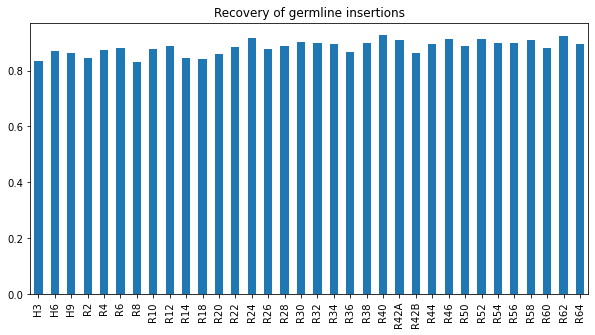

In [23]:
pd.DataFrame.from_dict(r).transpose()[2].plot(kind='bar', figsize=(10, 5), title="Recovery of germline insertions")

In [24]:
pd.DataFrame.from_dict(r).transpose()[2].describe()

count    34.000000
mean      0.883611
std       0.025654
min       0.830247
25%       0.867388
50%       0.887491
75%       0.899678
max       0.925342
Name: 2, dtype: float64

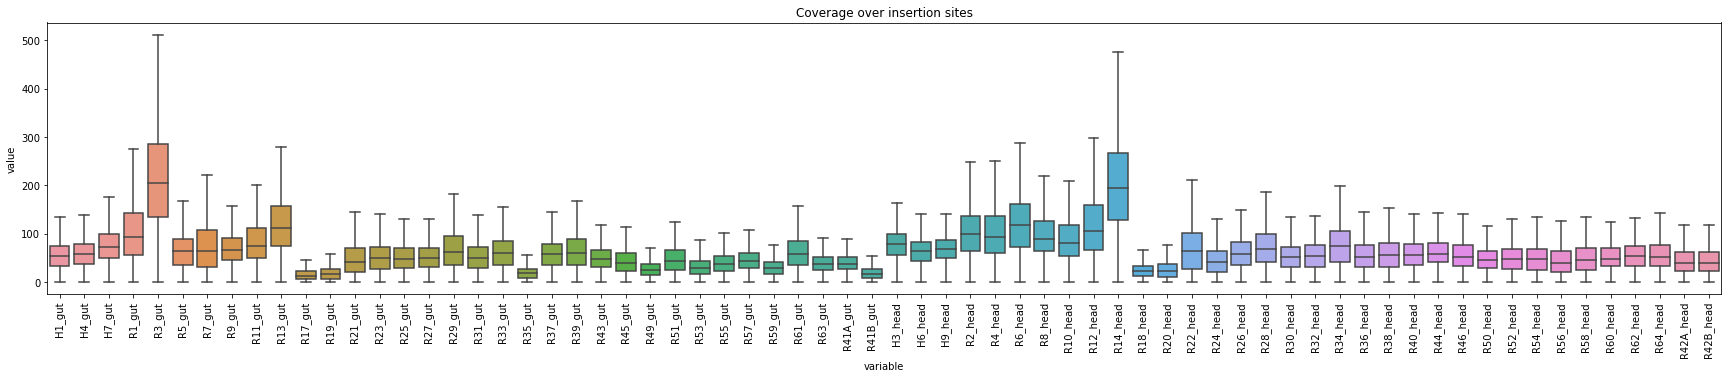

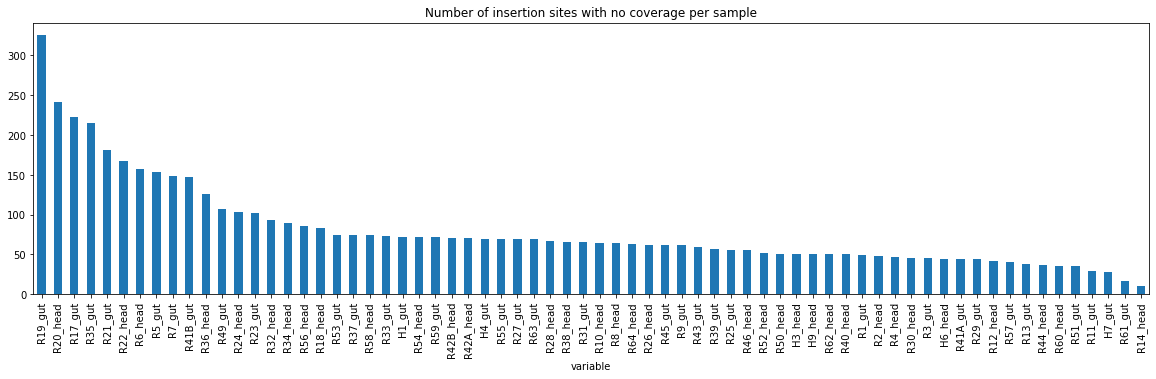

In [28]:
def plot_coverage_data(coverage_data):
    """describeCoverage over insertion sites"""
    fig, ax = plt.subplots(figsize=(30, 5))
    sns.boxplot(x='variable', y='value', showfliers = False, data=coverage_data, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title('Coverage over insertion sites')
    
    # Insertion sites without coverage
    fig, ax = plt.subplots(figsize=(30, 5))
    germline_sites_without_coverage = coverage_data['value'].eq(0).astype(int).groupby(coverage_data['variable']).sum().sort_values(ascending=False)
    germline_sites_without_coverage.plot(kind='bar', x='sample', y='count', figsize=(20, 5), title='Number of insertion sites with no coverage per sample', ax=ax)

coverage_data = final_table.iloc[:, 14:-2].melt()
plot_coverage_data(coverage_data)

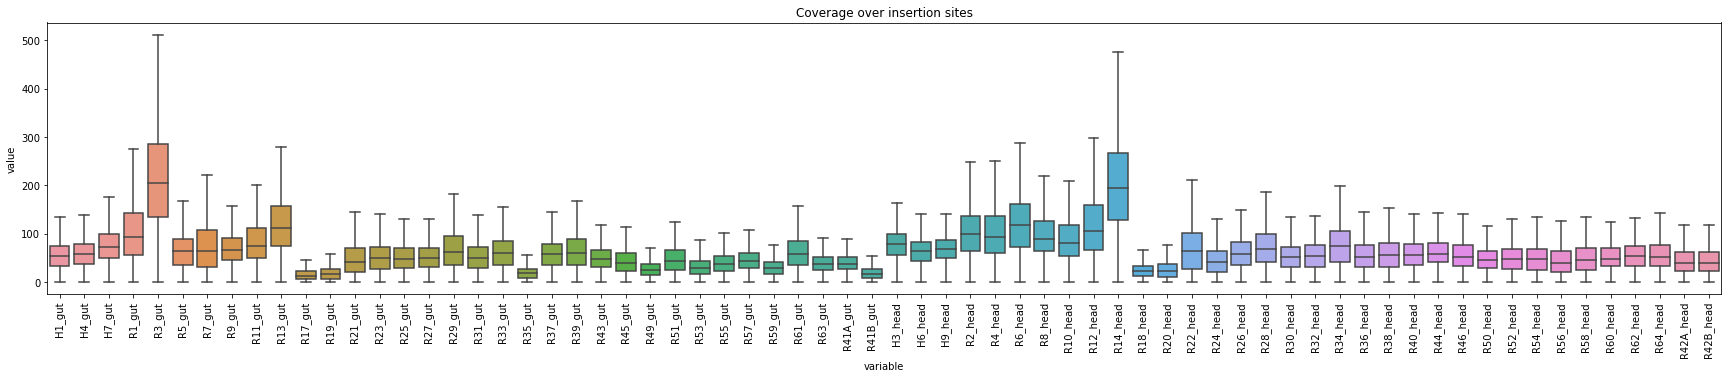

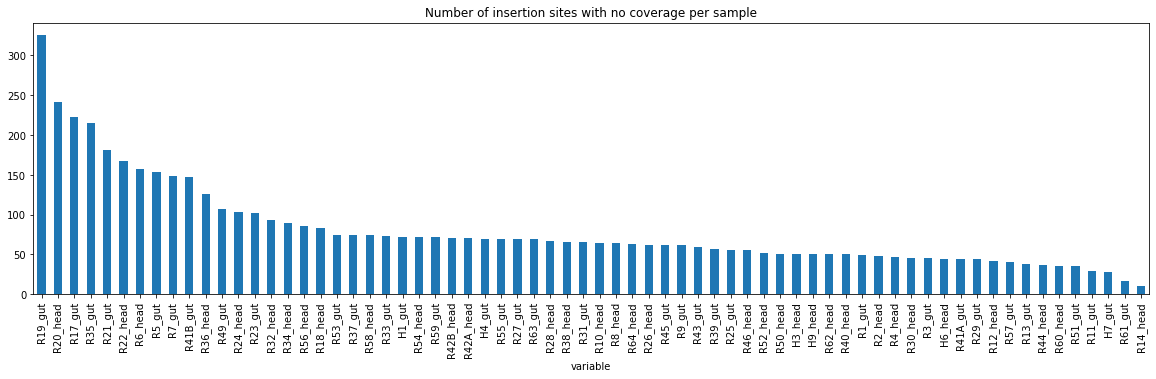

In [29]:
coverage_data = final_table[final_table.median_coverage >= 10].iloc[:, 14:-2].melt()
plot_coverage_data(coverage_data)

Text(0.5, 1.0, 'Germline private TE insertions')

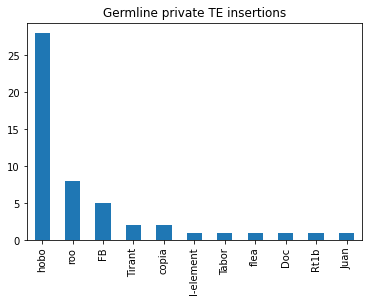

In [30]:
private_germline_insertions = final_table[(~final_table['early_developmental']) & (final_table['private'])]
private_germline_insertions.insertion.value_counts().plot(kind='bar').set_title('Germline private TE insertions')

In [31]:
private_germline_insertions[private_germline_insertions.median_coverage >= 10]

,index,chrom,start,end,insertion,strand,genotype,somatic,N_samples,overlaps,...,R54_head,R56_head,R58_head,R60_head,R62_head,R64_head,R42A_head,R42B_head,median_coverage,early_developmental
54,0,Y,2488664,2488712,Doc,+,heterozygous,False,2,"[R21, R22]",...,106,50,82,168,59,72,39,39,60.0,False
270,1,X,17592090,17592098,FB,+,homozygous,False,2,"[H7, H9]",...,51,27,30,56,51,67,46,46,48.0,False
335,0,X,14390484,14390489,copia,+,homozygous,False,2,"[R7, R8]",...,70,43,72,54,85,50,53,53,68.0,False
338,0,X,14273240,14273245,flea,+,homozygous,False,2,"[R8, R7]",...,62,71,73,51,66,80,54,54,61.0,False
361,1,X,12982792,12982796,roo,+,homozygous,False,2,"[R61, R62]",...,0,0,0,18,64,0,0,0,48.0,False
523,1,X,6943327,6943336,hobo,+,homozygous,False,2,"[R20, R19]",...,45,37,48,80,68,79,28,28,55.0,False
543,1,X,6314696,6314710,Rt1b,+,homozygous,False,2,"[R3, R4]",...,0,36,38,24,0,46,32,32,26.0,False
667,1,X,1149279,1149287,roo,+,homozygous,False,2,"[R30, R29]",...,33,0,0,44,22,2,0,0,26.0,False
670,1,X,998281,998287,roo,+,homozygous,False,2,"[R24, R23]",...,45,0,0,106,65,81,36,36,62.0,False
774,1,3R,31378960,31378968,hobo,+,heterozygous,False,2,"[R39, R40]",...,37,37,39,37,47,61,33,33,49.0,False


Text(0.5, 1.0, 'Germline private TE insertions')

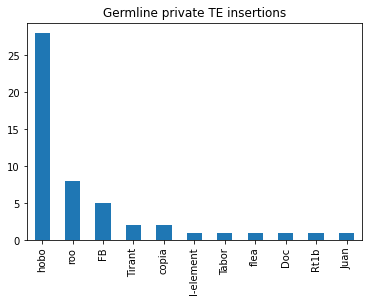

In [32]:
final_table = final_table[(final_table['median_coverage'] >=10) & (~final_table['early_developmental'])]
final_table[final_table['private']].insertion.value_counts().plot(kind='bar').set_title('Germline private TE insertions')

In [33]:
final_table.to_csv(FINAL_TABLE, sep='\t', index=None)

In [34]:
final_table.columns = [c.split('_')[0] for c in final_table.columns]

In [35]:
x = []
def expand_row(row):
    for index, (sample, vaf) in enumerate(zip(row['overlaps'], row['vaf'])):
        sample = sample.rsplit('_', 1)[0]
        coverage = row[sample]
        if sum(row['support'][index]) > 0:
            x.append((row['chrom'], row['start'], row['end'], row['insertion'], sample, coverage, vaf, row['N'], row['genotype']))

final_table.apply(lambda row: expand_row(row), axis=1)
coverage_per_insertion = pd.DataFrame.from_records(x)
coverage_per_insertion.columns = ['chrom', 'start', 'end', 'insertion', 'sample', 'coverage', 'vaf', 'N_samples', 'genotype']

/Users/mvandenb/miniconda3/envs/somatic-transposition-fly-intestine/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


LinregressResult(slope=-0.0004567693137591634, intercept=0.7313545134585026, rvalue=-0.05459673084934952, pvalue=1.2661851737261226e-08, stderr=8.020606374508893e-05)

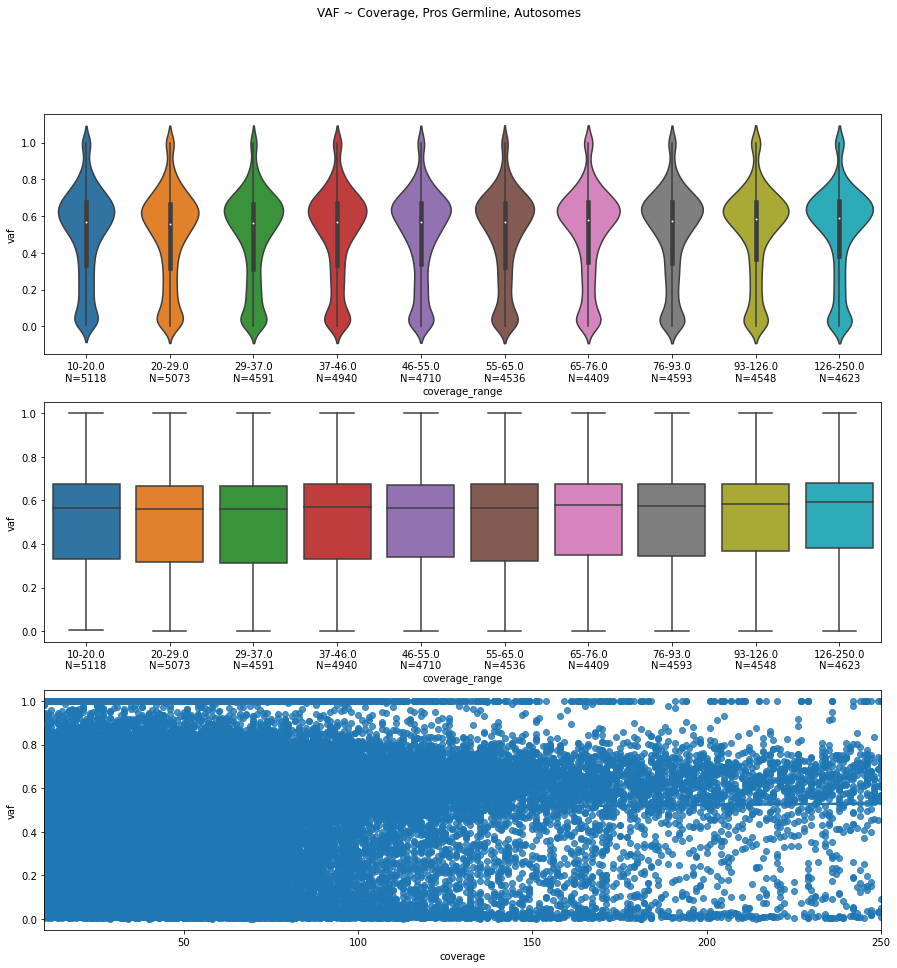

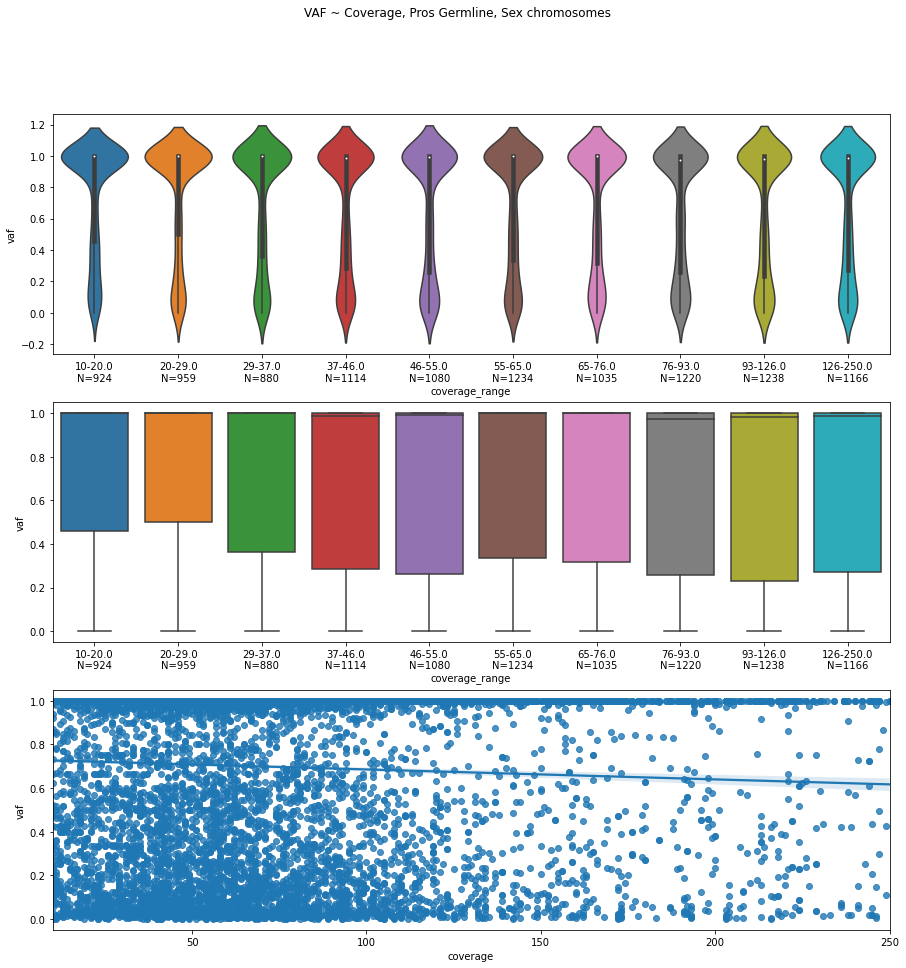

In [36]:
reasonable_coverage = coverage_per_insertion[(coverage_per_insertion.coverage >= 10) & (coverage_per_insertion.coverage <= 250)]
reasonable_coverage[reasonable_coverage.N_samples > 10]
reasonable_coverage['coverage_range'] = pd.qcut(reasonable_coverage.coverage, q=10)
autosomes = reasonable_coverage[~reasonable_coverage['chrom'].isin({'X', 'Y'})]
autosomes = autosomes[autosomes.genotype == 'heterozygous']
sex_chromosomes = reasonable_coverage[reasonable_coverage['chrom'].isin({'X', 'Y'})]

def plot_coverage_vaf_relationship(df, title='Coverage-VAF relationship'):
    fig, axes = plt.subplots(nrows=3, figsize=(15, 15))
    fig.suptitle(title)
    sns.violinplot(x='coverage_range', y='vaf', data=df, ax=axes[0])
    sns.boxplot(x='coverage_range', y='vaf', data=df, ax=axes[1])
    xlabels = df.coverage_range.value_counts().sort_index().reset_index().apply(lambda row: f"{round(row['index'].left)}-{row['index'].right}\nN={row['coverage_range']}", axis=1).to_list()
    axes[0].set_xticklabels(xlabels)
    axes[1].set_xticklabels(xlabels)
    sns.regplot(x='coverage', y='vaf', data=df, ax=axes[2])
    fig.savefig(f"{title}.pdf", bbox_inches='tight')
    return scipy.stats.linregress(df['coverage'], df['vaf'])


plot_coverage_vaf_relationship(autosomes, title=f'VAF ~ Coverage, {PREFIX}, Autosomes')
plot_coverage_vaf_relationship(sex_chromosomes, title=f'VAF ~ Coverage, {PREFIX}, Sex chromosomes')


In [37]:
scipy.stats.linregress(autosomes['coverage'], autosomes['vaf'])

LinregressResult(slope=0.0001429508645433413, intercept=0.49425896878743886, rvalue=0.02565459515245048, pvalue=2.5344242992166824e-08, stderr=2.5655972047862406e-05)

In [38]:
scipy.stats.pearsonr(autosomes['coverage'], autosomes['vaf'])

(0.02565459515245047, 2.5344242992946025e-08)

In [39]:
final_table.genotype.value_counts()

heterozygous    1413
homozygous       451
Name: genotype, dtype: int64

In [40]:
autosomes.genotype.value_counts()

heterozygous    47141
Name: genotype, dtype: int64

In [41]:
sex_chromosomes.genotype.value_counts()

homozygous      6905
heterozygous    3945
Name: genotype, dtype: int64

<AxesSubplot:>

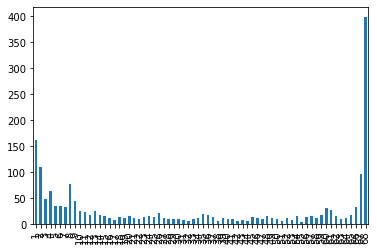

In [43]:
final_table.N.value_counts().sort_index().plot(kind='bar')

In [44]:
final_table = final_table[(final_table.N > 0) & (final_table['median'] >= 10)]

<AxesSubplot:>

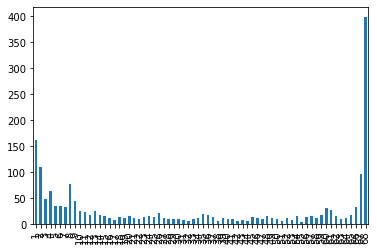

In [45]:
final_table.N.value_counts().sort_index().plot(kind='bar')

In [46]:
final_table

,index,chrom,start,end,insertion,strand,genotype,somatic,N,overlaps,...,R54,R56,R58,R60,R62,R64,R42A,R42B,median,early
1,2,Y,3625759,3625762,gtwin,+,homozygous,False,8,"[R18, R58, R2, R49, R12, R1, R39, R46, R18, R2]",...,41,41,58,40,81,49,41,41,58.0,False
2,9,Y,3625759,3625762,HeT-A,+,homozygous,False,13,"[R33, R9, R11, R3, R13, R54, R4, R34, R38, R8,...",...,41,41,58,40,81,49,41,41,58.0,False
6,7,Y,3619774,3619779,rover,+,homozygous,False,57,"[R58, R27, R4, R42A, R45, R51, R49, R37, R62, ...",...,74,73,73,46,91,54,56,56,79.0,False
7,5,Y,3601991,3602029,accord2,+,heterozygous,False,25,"[R38, R3, R9, R43, R26, R43, R60, R26, R7, R59...",...,37,46,35,46,63,39,31,31,46.0,False
9,1,Y,3600987,3600990,blood,+,heterozygous,False,57,"[R26, R52, R41B, R17, R39, R44, R46, R7, R54, ...",...,58,57,61,56,77,71,59,59,67.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3394,63,2L,589467,589483,FB,+,heterozygous,False,68,"[R3, R22, R24, R17, R53, R52, R42B, R4, R30, R...",...,44,32,33,24,42,63,28,28,29.0,False
3398,1,2L,171710,171713,springer,+,heterozygous,False,3,"[H9, H7, R1]",...,27,27,22,30,25,26,26,26,25.0,False
3399,0,2L,140056,140060,opus,+,heterozygous,False,1,[R6],...,27,27,22,30,25,26,26,26,25.0,False
3400,60,2L,140056,140060,roo,+,homozygous,False,67,"[R35, R2, R41B, R7, R56, R24, R32, R64, R1, R3...",...,27,27,22,30,25,26,26,26,25.0,False


In [47]:
fully_penetrant

NameError: name 'fully_penetrant' is not defined

In [ ]:
private_germline_insertions[private_germline_insertions.median_coverage > 10].insertion.value_counts().

In [48]:
51 / 34

1.5

In [49]:
autosomes.vaf.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

count    47141.000000
mean         0.503552
std          0.253966
min          0.000648
5%           0.019608
25%          0.339623
50%          0.571429
75%          0.673267
95%          0.843750
max          1.000000
Name: vaf, dtype: float64

In [50]:
autosomes[autosomes.coverage > 10].vaf.median()

0.5714285714285714

In [51]:
autosomes.vaf.describe(percentiles=[0.05, 0.95])

count    47141.000000
mean         0.503552
std          0.253966
min          0.000648
5%           0.019608
50%          0.571429
95%          0.843750
max          1.000000
Name: vaf, dtype: float64

In [63]:
x = autosomes[autosomes.N_samples == 68]

In [66]:
x.vaf.median()

0.6219512195121951

In [64]:
x.vaf.describe(percentiles=[0.05, 0.95])

count    21501.000000
mean         0.584192
std          0.205627
min          0.000648
5%           0.055556
50%          0.621951
95%          0.848485
max          1.000000
Name: vaf, dtype: float64